In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor/2/1231.png

/kaggle/input/brain-tumor/2/641.png

/kaggle/input/brain-tumor/2/1088.png

/kaggle/input/brain-tumor/2/173.png

/kaggle/input/brain-tumor/2/1958.png

/kaggle/input/brain-tumor/2/815.png

/kaggle/input/brain-tumor/2/491.png

/kaggle/input/brain-tumor/2/1924.png

/kaggle/input/brain-tumor/2/1084.png

/kaggle/input/brain-tumor/2/718.png

/kaggle/input/brain-tumor/2/709.png

/kaggle/input/brain-tumor/2/889.png

/kaggle/input/brain-tumor/2/379.png

/kaggle/input/brain-tumor/2/780.png

/kaggle/input/brain-tumor/2/248.png

/kaggle/input/brain-tumor/2/94.png

/kaggle/input/brain-tumor/2/480.png

/kaggle/input/brain-tumor/2/1145.png

/kaggle/input/brain-tumor/2/1944.png

/kaggle/input/brain-tumor/2/236.png

/kaggle/input/brain-tumor/2/1343.png

/kaggle/input/brain-tumor/2/771.png

/kaggle/input/brain-tumor/2/675.png

/kaggle/input/brain-tumor/2/340.png

/kaggle/input/brain-tumor/2/48.png

/kaggle/input/brain-tumor/2/1948.png

/kaggle/input/brain-tumor/2/187

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import shutil
from tensorflow.keras import regularizers

from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.models import load_model

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Dropout, MaxPool2D , Activation, Flatten, Dense, AvgPool2D, Lambda, BatchNormalization, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [3]:
!pip install visualkeras
!pip install openpyxl






     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.8/989.8 kB 23.9 MB/s eta 0:00:0000:01










In [4]:
import visualkeras

In [5]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch

In [6]:
data_dir = '../input/brain-tumor' 
class_names = os.listdir(data_dir)
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
               for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]

In [7]:
N=['1','2','3']
Name=[ 'meningioma','glioma','pituitary tumor' ]
normal_mapping=dict(zip(Name,N))
reverse_mapping=dict(zip(N,Name))

In [8]:
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

In [9]:
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 3064

Image dimensions: 512 x 512

Label names: ['2', '3', '1']

Label counts: [1426, 930, 708]


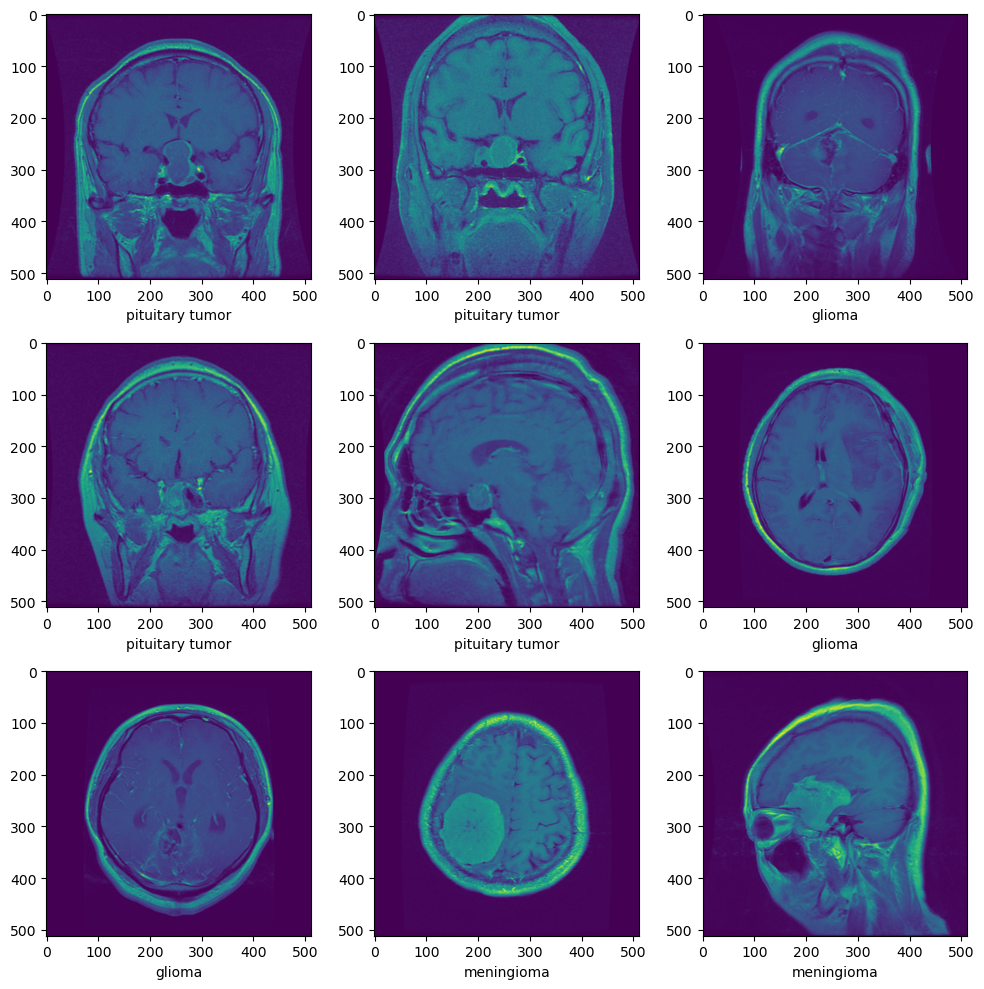

In [10]:
plt.subplots(3,3, figsize=(10,10))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3,3, i+1)
    plt.xlabel(reverse_mapping[class_names[image_label_list[k]]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [11]:
len(image_file_list)

3064

In [12]:
len(image_label_list)

3064

In [13]:
set(image_label_list)

{0, 1, 2}

In [14]:
data_df = pd.DataFrame({'image_file_path': image_file_list, 'label': image_label_list})

In [15]:
data_df.head(5)

,image_file_path,label
0,../input/brain-tumor/2/1231.png,0
1,../input/brain-tumor/2/641.png,0
2,../input/brain-tumor/2/1088.png,0
3,../input/brain-tumor/2/173.png,0
4,../input/brain-tumor/2/1958.png,0


In [16]:
data_df.isna().sum()

image_file_path    0
label              0
dtype: int64

<AxesSubplot:>

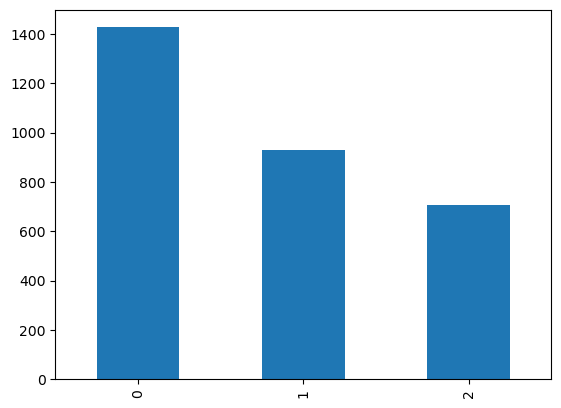

In [20]:
data_df["label"].value_counts().plot.bar()

In [17]:
#All the images are having same dimensions
for img_path in data_df["image_file_path"][:10]:
    print(Image.open(img_path).size)

(512, 512)

(512, 512)

(512, 512)

(512, 512)

(512, 512)

(512, 512)

(512, 512)

(512, 512)

(512, 512)

(512, 512)


**Common parameters for all the models**

In [18]:
evaluation_metrics = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, 0]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap_resized = resize(heatmap,(320, 256))
    return heatmap_resized

In [21]:
N=[0,1,2]
reverse_mapping=dict(zip(N,Name))
reverse_mapping

{0: 'meningioma', 1: 'glioma', 2: 'pituitary tumor'}

In [22]:
data_df['label'] = data_df['label'].map(reverse_mapping).fillna(data_df['label'])

In [23]:
data_df.head(2)

,image_file_path,label
0,../input/brain-tumor/2/1231.png,meningioma
1,../input/brain-tumor/2/641.png,meningioma


**Train test split**

In [24]:
train_val_dataset, test_dataset = train_test_split(data_df, test_size=0.2, shuffle=True, random_state=42)

**Train Validation Set split**

In [25]:
train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.15, shuffle=True, random_state=42)

**Please refer to this notebook from this cell. The above part is implemented in the other notebook, which is in the same GitHub Repo folder.**

**Transfer Learning Xception model**

Define two ImageDataGenerator objects train_generator and test_generator for data augmentation and preprocessing of images. The train_generator applies several image transformations such as zoom, brightness adjustment, and shifting, and normalizes the data. The test_generator only applies data normalization.

In [51]:
#Now let's do data augmentation
train_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input,
                                   zoom_range=[0.75, 1],
                                   brightness_range=(0.8, 1.2),
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True)
test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

Define two image generators (train_img_gen and val_img_gen) using the flow_from_dataframe method of a Keras ImageDataGenerator object. The generators will load and preprocess the images from the specified dataframes (train_dataset and val_dataset) and create batches of 64 images each with their corresponding labels in one-hot encoded format. The images will be resized to 256x256 pixels.

In [52]:
train_img_gen = train_generator.flow_from_dataframe(
    dataframe=train_dataset,
    x_col='image_file_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 2083 validated image filenames belonging to 3 classes.


In [53]:
val_img_gen = train_generator.flow_from_dataframe(
    dataframe=val_dataset,
    #directory=train_set_folder_path,
    x_col='image_file_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 368 validated image filenames belonging to 3 classes.


Define a data generator for testing data. It takes in a pandas dataframe containing the image file paths and their corresponding labels, and generates batches of 64 preprocessed images of size 256x256 along with their labels. The generated data is not shuffled.

In [54]:
test_img_gen = test_generator.flow_from_dataframe(
                              dataframe=test_dataset,
                              x_col='image_file_path',
                              y_col='label',
                              target_size=(256, 256),
                              batch_size=64,
                              seed=2022,
                              shuffle=False)

Found 613 validated image filenames belonging to 3 classes.


**Xception model Pre-processed image visualization**

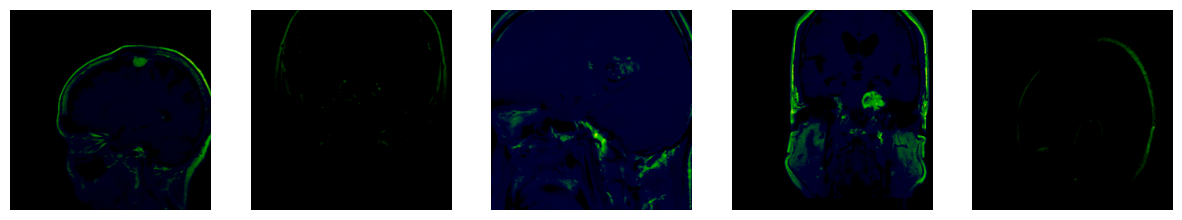

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(train_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

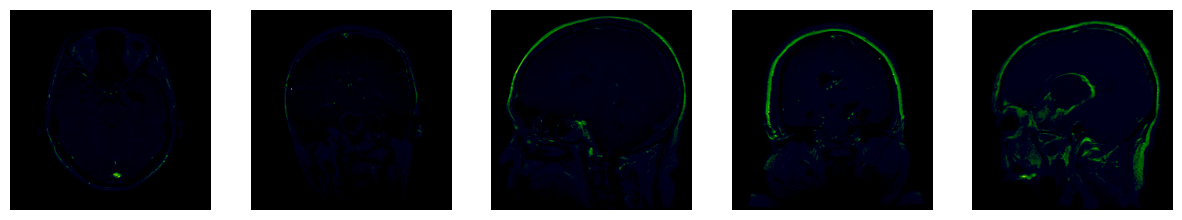

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(test_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

**Let's take the already pre-trained Xception model and apply the transfer learning on our problem set**

In [57]:
#From professor's notebook, need to implement below callback part

model_path = "/kaggle/working/best_xception_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

monitor = tf.keras.callbacks.ModelCheckpoint(model_path,
                                             monitor='val_loss',
                                             verbose=1,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def schedule(epoch, lr):
    if epoch%3 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(schedule,verbose = 1)

model_callbacks = [
    early_stop, 
    lr_schedule,
    monitor]

Define a custom neural network architecture by utilizing the pre-trained Xception model as the base layer. The last layer of the Xception model is extracted and used as an input for the custom layers. The custom layers include global average pooling, dropout, and fully connected layers with different numbers of neurons and activation functions. Finally, the output layer has 3 neurons with a softmax activation function for multi-class classification.

In [58]:
# inputs = tf.keras.layers.Input((312,312,3))
# Xception_model=tf.keras.applications.xception.Xception(include_top=False, weights="imagenet",input_shape=(312,312,3), pooling='avg')
# last_layer = Xception_model.get_layer('block14_sepconv2_act')
# last_output = last_layer.output
# input_l = Xception_model.input
# base_model1 = tf.keras.Model(input_l, last_output)

# x = base_model1(inputs)
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.25)(x)
# x = Dense(2048, activation = "relu")(x)
# x = Dropout(0.25)(x)
# x = Dense(512, activation = "relu")(x)
# x = Dropout(0.25)(x)
# x = Dense(64, activation = "relu")(x)
# x = Dropout(0.25)(x)
# outputs = Dense(3, activation = "softmax")(x)

# Xception_transfer_learning_model = tf.keras.Model(inputs, outputs)

Define a convolutional neural network (CNN) model for multi-class classification. The base_model is a pre-trained Xception model from the ImageNet dataset, and it is followed by a BatchNormalization layer, a Dense layer with L1 and L2 regularization, a Dropout layer, and finally, an output Dense layer with softmax activation function for three classes.

In [59]:
base_model = tf.keras.applications.xception.Xception(include_top=False, weights="imagenet",input_shape=(256, 256, 3), pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(3, activation= 'softmax')
])


83683744/83683744 [==============================] - 2s 0us/step


Compile the model by specifying the optimizer, loss function, and evaluation metric to be used during training. In this case, the Adam optimizer is used with a learning rate of 0.0005, categorical cross-entropy is used as the loss function, and accuracy is used as the evaluation metric.

In [60]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0005), loss= 'categorical_crossentropy', metrics= ['accuracy'])
# Xception_transfer_learning_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=evaluation_metrics)

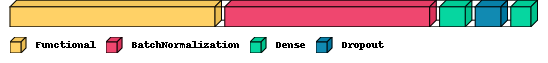

In [62]:
from PIL import ImageFont
# font = ImageFont.truetype("../input/arialfont/arial.ttf", 12)
visualkeras.layered_view(model, to_file='model_architecture_xception.png', legend=True
#                          , font=font
                        )

**Model Training**

In [64]:
Actual_epochs = 30

for i in range(Actual_epochs):
    model_progress = model.fit(
        train_img_gen,
        batch_size=10240,
        steps_per_epoch = 64,
        validation_data = val_img_gen,
        #epochs = 60,
        epochs = 1,
        callbacks=model_callbacks
    )

    model.save(model_path)



Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.

33/64 [==============>...............] - ETA: 1:07 - loss: 8.0136 - accuracy: 0.7849

Epoch 1: val_loss improved from inf to 7.55744, saving model to /kaggle/working/best_xception_cnn.h5

64/64 [==============================] - 120s 1s/step - loss: 8.0136 - accuracy: 0.7849 - val_loss: 7.5574 - val_accuracy: 0.6304 - lr: 5.0000e-04



Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.

33/64 [==============>...............] - ETA: 1:06 - loss: 5.8850 - accuracy: 0.9347

Epoch 1: val_loss improved from 7.55744 to 6.03556, saving model to /kaggle/working/best_xception_cnn.h5

64/64 [==============================] - 85s 1s/step - loss: 5.8850 - accuracy: 0.9347 - val_loss: 6.0356 - val_accuracy: 0.7255 - lr: 5.0000e-04



Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.

33/64 [==============>...............] - ETA: 1:07 - loss: 4.5431 - accuracy: 0

Predict the class labels for the test images using the trained model, then it converts the class indices to class labels using a dictionary that maps the class indices to their respective labels.

In [67]:
test_pred= model.predict(test_img_gen)
predicted_class=np.argmax(test_pred,axis=1)
class_labels = (test_img_gen.class_indices)
prediction = [dict((v,i) for i,v in class_labels.items())[i] for i in predicted_class]
print("Predicted :", predicted_class[:5])
actual_label = test_img_gen.classes
print("actual_label: ", actual_label[:5])

10/10 [==============================] - 14s 1s/step

Predicted : [1 1 1 0 0]

actual_label:  [1, 1, 1, 0, 0]


**Accuracy**

In [68]:
accuracy = accuracy_score(predicted_class,actual_label)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.41%


**Plot consfusion metrics**

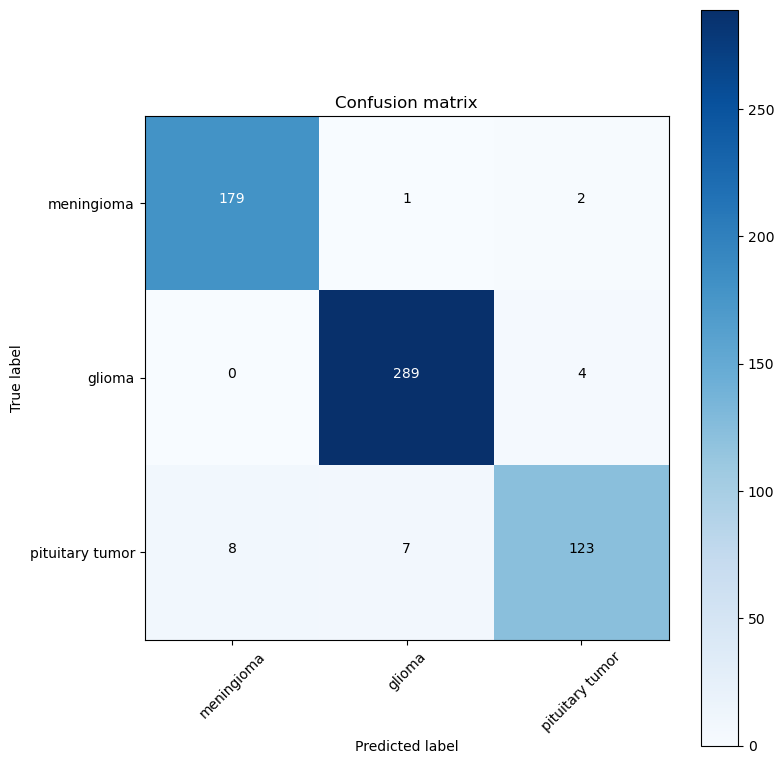

In [69]:
cnf_matrix = confusion_matrix(actual_label, predicted_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=[ 'meningioma','glioma','pituitary tumor'],
                      title='Confusion matrix')
plt.show()

**All the steps from the above Xception model are implemented below but with respect to InceptionV3 model**

**Transfer Learning InceptionV3 model**

In [26]:
#Now let's do data augmentation
train_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
                                   zoom_range=[0.75, 1],
                                   brightness_range=(0.8, 1.2),
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True)
test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

In [27]:
train_img_gen = train_generator.flow_from_dataframe(
    dataframe=train_dataset,
    x_col='image_file_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 2083 validated image filenames belonging to 3 classes.


In [28]:
val_img_gen = train_generator.flow_from_dataframe(
    dataframe=val_dataset,
    x_col='image_file_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 368 validated image filenames belonging to 3 classes.


In [29]:
test_img_gen = test_generator.flow_from_dataframe(
                              dataframe=test_dataset,
                              x_col='image_file_path',
                              y_col='label',
                              target_size=(256, 256),
                              batch_size=64,
                              seed=2022,
                              shuffle=False)

Found 613 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

  "This ImageDataGenerator specifies "

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

  "This ImageDataGenerator specifies "


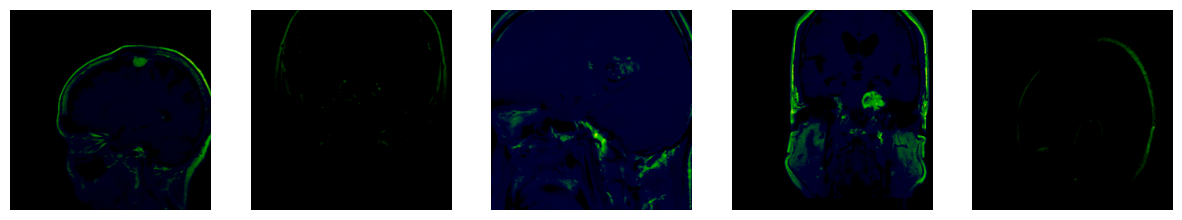

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(train_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

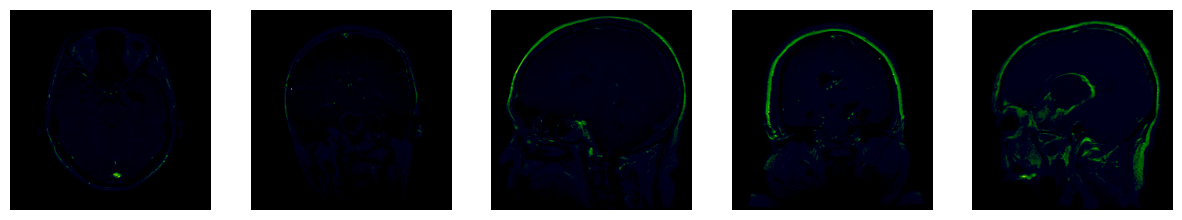

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(test_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

In [32]:
#From professor's notebook, need to implement below callback part

model_path = "/kaggle/working/best_inception_tumor_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

monitor = tf.keras.callbacks.ModelCheckpoint(
    model_path,
    monitor='val_loss',\
                                             verbose=1,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def schedule(epoch, lr):
    if epoch%3 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(schedule,verbose = 1)

model_callbacks = [early_stop, lr_schedule, monitor]

In [33]:
inputs = tf.keras.layers.Input((256,256,3))
Inception_model=tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', pooling='max', input_shape=(256, 256, 3))

x = Inception_model(inputs)
x = Dropout(0.25)(x)
x = Dense(2048, activation = "relu")(x)
x = Dropout(0.25)(x)
x = Dense(512, activation = "relu")(x)
x = Dropout(0.25)(x)
x = Dense(64, activation = "relu")(x)
x = Dropout(0.25)(x)
outputs = Dense(3, activation = "softmax")(x)

Inception_transfer_learning_model = tf.keras.Model(inputs, outputs)


87910968/87910968 [==============================] - 0s 0us/step


In [35]:
Inception_transfer_learning_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=evaluation_metrics)

In [36]:
Actual_epochs = 30

for i in range(Actual_epochs):
    model_progress = Inception_transfer_learning_model.fit(
        train_img_gen,
        batch_size=10240,
        steps_per_epoch = 64,
        validation_data = val_img_gen,
        #epochs = 10,
        epochs = 1,
        callbacks=model_callbacks
    )
    
    Inception_transfer_learning_model.save(model_path)



Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.

33/64 [==============>...............] - ETA: 1:17 - loss: 1.1363 - tp: 826.0000 - fp: 604.0000 - tn: 3562.0000 - fn: 1257.0000 - accuracy: 0.7022 - precision: 0.5776 - recall: 0.3965

Epoch 1: val_loss improved from inf to 3.87142, saving model to /kaggle/working/best_inception_tumor_cnn.h5

64/64 [==============================] - 156s 2s/step - loss: 1.1363 - tp: 826.0000 - fp: 604.0000 - tn: 3562.0000 - fn: 1257.0000 - accuracy: 0.7022 - precision: 0.5776 - recall: 0.3965 - val_loss: 3.8714 - val_tp: 156.0000 - val_fp: 212.0000 - val_tn: 524.0000 - val_fn: 212.0000 - val_accuracy: 0.6159 - val_precision: 0.4239 - val_recall: 0.4239 - lr: 5.0000e-04



Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.

33/64 [==============>...............] - ETA: 1:01 - loss: 0.4985 - tp: 1482.0000 - fp: 278.0000 - tn: 3888.0000 - fn: 601.0000 - accuracy: 0.8593 - precision: 0.8420 - recal

In [39]:
test_pred= Inception_transfer_learning_model.predict(test_img_gen)
predicted_class=np.argmax(test_pred,axis=1)
class_labels = (test_img_gen.class_indices)
prediction = [dict((v,i) for i,v in class_labels.items())[i] for i in predicted_class]
print("Predicted :", predicted_class[:5])
actual_label = test_img_gen.classes
print("actual_label: ", actual_label[:5])

10/10 [==============================] - 15s 1s/step

Predicted : [1 1 1 0 0]

actual_label:  [1, 1, 1, 0, 0]


In [40]:
accuracy = accuracy_score(predicted_class,actual_label)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.78%


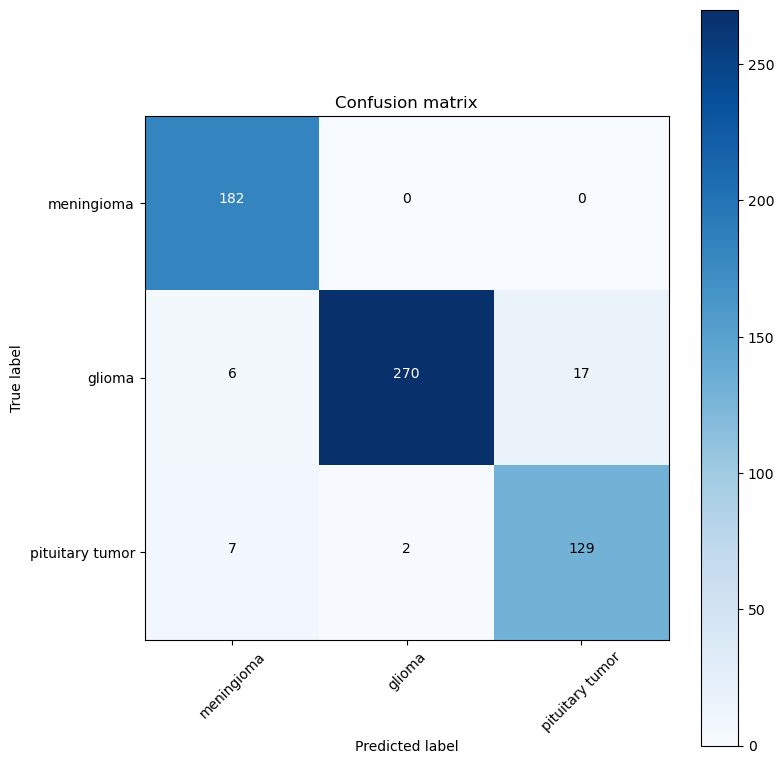

In [41]:
cnf_matrix = confusion_matrix(actual_label, predicted_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=[ 'meningioma','glioma','pituitary tumor'],
                      title='Confusion matrix')
plt.show()

**MONAI**

All the reference of MONAI implementation taken from below GitHub Notebook:

https://github.com/Project-MONAI/tutorials/blob/main/2d_classification/mednist_tutorial.ipynb


Check if the Monai package is installed in the current environment. If it is not installed, then it installs the monai-weekly package along with pillow and tqdm as dependencies. Monai is a deep learning framework for medical image analysis that provides a set of easy-to-use, extensible, and modular tools and models to enable researchers to create sophisticated medical imaging workflows.

In [17]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
%matplotlib inline

Traceback (most recent call last):

  File "<string>", line 1, in <module>

ModuleNotFoundError: No module named 'monai'




In [18]:
#Import all the required libraries
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.transforms import *
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.2.dev2312

Numpy version: 1.21.6

Pytorch version: 1.13.0+cpu

MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False

MONAI rev id: 400a6a052f1b2925db6f1323a67a7cf4546403eb

MONAI __file__: /opt/conda/lib/python3.7/site-packages/monai/__init__.py



Optional dependencies:

Pytorch Ignite version: 0.4.11

ITK version: NOT INSTALLED or UNKNOWN VERSION.

Nibabel version: 4.0.2

scikit-image version: 0.19.3

Pillow version: 9.3.0

Tensorboard version: 2.11.2

gdown version: NOT INSTALLED or UNKNOWN VERSION.

TorchVision version: 0.14.0+cpu

tqdm version: 4.64.1

lmdb version: NOT INSTALLED or UNKNOWN VERSION.

psutil version: 5.9.3

pandas version: 1.3.5

einops version: NOT INSTALLED or UNKNOWN VERSION.

transformers version: 4.26.1

mlflow version: NOT INSTALLED or UNKNOWN VERSION.

pynrrd version: NOT INSTALLED or UNKNOWN VERSION.



For details about installing the optional dependencies, please visit:

    https://docs.monai.io/en/latest/installatio

In [19]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(image_file_list, image_label_list, test_size=0.2, random_state=42)

In [20]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.15, random_state=42)

Define two custom transform classes inherited from the MONAI Transform class. SumDimension calculates the sum along a given dimension of the input tensor, while MyResize resizes the input image to a given size using OpenCV's cv2.resize() function with bicubic interpolation. These custom transforms can be used in MONAI's pipelines for preprocessing or augmenting medical images.

In [23]:
# Define a class to sum along a specific dimension of a tensor.
class SumDimension(Transform):
    def __init__(self, dim=1):
        self.dim = dim
    
    # Implement a __call__ method to apply the transformation to input data.
    def __call__(self, inputs):
        return inputs.sum(self.dim)

# Define a class to resize images to a specific size.
class MyResize(Transform):
    def __init__(self, size=(256,256)):
        self.size = size
    
    # Implement a __call__ method to apply the transformation to input data.
    def __call__(self, inputs):
        # Use OpenCV library to resize the input image to the desired size.
        image2 = cv2.resize(np.array(inputs), dsize=(self.size[1],self.size[0]), interpolation=cv2.INTER_CUBIC)
        return image2

Define three transformations for input images and their corresponding labels: train_transforms, val_transforms, y_trans. train_transforms and val_transforms apply a set of image processing techniques such as resizing, rotating, flipping, and zooming. y_pred_trans applies softmax activation to the predicted output, while y_trans converts the labels to one-hot encoding.

In [25]:
# Define a set of image augmentations to be applied during the training of a machine learning 
# model. The augmentations include loading an image, resizing it, adding a channel, 
# converting to a tensor, and randomly rotating, flipping, and zooming the image to increase 
# the variability of the training data.
train_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    SumDimension(2),
    MyResize(),
    AddChannel(),    
    ToTensor(),
    RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5)
])


# The val_transforms variable creates a set of image transformations to be applied to 
# the validation dataset, including loading the image, resizing it, adding a channel 
# dimension, and converting it to a PyTorch tensor.
val_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    SumDimension(2),
    MyResize(),
    AddChannel(),    
    ToTensor(),
])

# The y_pred_trans variable creates a set of transformations to be applied to the model's 
#predicted output, which applies a softmax activation function.
y_pred_trans = Compose([Activations(softmax=True)])

# The y_trans variable creates a set of transformations to be applied to the ground truth 
# labels, which converts them to one-hot encoded tensors.
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

/opt/conda/lib/python3.7/site-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.

  warn_deprecated(obj, msg, warning_category)


This code defines a custom dataset class, MedNISTDataset, that inherits from torch.utils.data.Dataset. The class takes in image files, labels, and transforms as inputs, and has methods to get the length of the dataset and to get an item (image and label) at a particular index. The transforms argument is used to apply any transformations to the image before returning it.

In [26]:
#This class represents a dataset for the MedNIST dataset with images and labels.
class MedNISTDataset(torch.utils.data.Dataset):
    #The constructor initializes the image files, labels, and transformations.
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
    
    #The len method returns the length of the dataset.
    def __len__(self):
        return len(self.image_files)
    
    #The getitem method retrieves an image and its corresponding label at a given index, and applies the defined transformations to the image.
    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

Below lines of code create PyTorch data loaders for the training, validation, and test datasets. The training and validation datasets use different sets of transformations specified by train_transforms and val_transforms, respectively, while the test dataset uses the same transformations as the validation dataset. batch_size specifies the number of samples per batch, and num_workers specifies the number of subprocesses used to load the data.

In [27]:
# Create training dataset and loader
train_ds = MedNISTDataset(X_train, Y_train, train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)

# Create validation dataset and loader
val_ds = MedNISTDataset(X_val, Y_val, val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, num_workers=2)

# Create test dataset and loader
test_ds = MedNISTDataset(X_test, Y_test, val_transforms)
test_loader = DataLoader(test_ds, batch_size=64, num_workers=2)

Set up the device to use either a GPU or CPU based on availability, initializes a DenseNet121 model with 2D spatial dimensions, 1 input channel, and 3 output channels. It defines the loss function as Cross Entropy Loss, optimizer as Adam with learning rate 1e-5, and specifies a maximum number of epochs and a validation interval. It also initializes an ROC-AUC metric to be used during evaluation.

In [28]:
# device is initialized as the available CUDA device, otherwise, as the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# An instance of the DenseNet121 model is created with 2D spatial dimensions, 1 input channel, and 3 output channels and moved to the specified device.
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=3).to(device)

# Cross-entropy loss function, Adam optimizer with a learning rate of 1e-5, and maximum epochs of 4 are initialized.
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

# val_interval is set to 1, and an instance of ROCAUCMetric is created to evaluate the model's performance.
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

In [29]:
device

device(type='cpu')

Perform training and validation of a neural network model for image classification. The training process is repeated for a specified number of epochs, where each epoch involves iterating through the training data in batches, performing forward and backward propagation to update the model parameters using the Adam optimizer and Cross Entropy loss function. At regular intervals, the model is evaluated on the validation data, and the ROC AUC metric is calculated to determine the model's performance. If the model achieves the best ROC AUC value so far, the model's state is saved. Finally, the best-performing model's state is returned.

In [36]:
best_metric = -1  # initializing the best metric value to -1
best_metric_epoch = -1  # initializing the best metric epoch to -1
epoch_loss_values = []  # an empty list to store the epoch loss values
metric_values = []  # an empty list to store the metric values
max_epochs = 25  # maximum number of epochs to train the model
root_dir = "/kaggle/working"  # root directory to save the model checkpoints

for epoch in range(max_epochs):  # looping through each epoch
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()  # setting the model to training mode
    epoch_loss = 0  # initializing the epoch loss to 0
    step = 0  # initializing the step counter to 0
    for batch_data in train_loader:  # looping through the batches in the training data loader
        step += 1  # incrementing the step counter
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)  # moving the batch data to device (CPU/GPU)
        optimizer.zero_grad()  # zeroing out the gradients from the previous step
        outputs = model(inputs)  # passing the inputs through the model to get the outputs
        loss = loss_function(outputs, labels)  # calculating the loss using the CrossEntropyLoss function
        loss.backward()  # calculating the gradients
        optimizer.step()  # updating the model parameters using the optimizer
        epoch_loss += loss.item()  # adding the loss to the epoch loss
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")  # printing the loss for each step
        epoch_len = len(train_ds) // train_loader.batch_size  # calculating the epoch length
    epoch_loss /= step  # averaging the epoch loss
    epoch_loss_values.append(epoch_loss)  # appending the epoch loss to the list
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")  # printing the average loss for the epoch

    if (epoch + 1) % val_interval == 0:  # run validation at set intervals
        model.eval()  # switch model to evaluation mode
        with torch.no_grad():  # disable gradient computation
            y_pred = torch.tensor([], dtype=torch.float32, device=device)  # initialize tensor for predicted labels
            y = torch.tensor([], dtype=torch.long, device=device)  # initialize tensor for ground truth labels
            for val_data in val_loader:  # loop over validation dataset
                val_images, val_labels = (val_data[0].to(device), val_data[1].to(device))  # move data to device
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)  # append predicted labels to y_pred tensor
                y = torch.cat([y, val_labels], dim=0)  # append ground truth labels to y tensor
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]  # convert ground truth labels to one-hot format
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]  # convert predicted labels to activation format
            auc_metric(y_pred_act, y_onehot)  # compute AUC metric
            result = auc_metric.aggregate()  # get the aggregate AUC value
            auc_metric.reset()  # reset the AUC metric
            del y_pred_act, y_onehot  # delete unnecessary tensors
            metric_values.append(result)  # append AUC value to metric_values list
            acc_value = torch.eq(y_pred.argmax(dim=1), y)  # compute accuracy value
            acc_metric = acc_value.sum().item() / len(acc_value)  # compute accuracy metric
            if result > best_metric:  # if current AUC is better than previous best AUC
                best_metric = result  # update best AUC value
                best_metric_epoch = epoch + 1  # update best AUC epoch
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))  # save the best model
                print("saved new best metric model")  # print message
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )  # print the current epoch and metric values
            
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")  # print the final best metric values


----------

epoch 1/25

1/32, train_loss: 0.8126

2/32, train_loss: 0.7184

3/32, train_loss: 0.7492

4/32, train_loss: 0.7927

5/32, train_loss: 0.7776

6/32, train_loss: 0.8304

7/32, train_loss: 0.7882

8/32, train_loss: 0.6849

9/32, train_loss: 0.6887

10/32, train_loss: 0.7408

11/32, train_loss: 0.7764

12/32, train_loss: 0.8001

13/32, train_loss: 0.6449

14/32, train_loss: 0.7319

15/32, train_loss: 0.7875

16/32, train_loss: 0.7357

17/32, train_loss: 0.7502

20/32, train_loss: 0.6774

21/32, train_loss: 0.6525

22/32, train_loss: 0.7759

23/32, train_loss: 0.6109

24/32, train_loss: 0.6926

25/32, train_loss: 0.5744

26/32, train_loss: 0.7642

27/32, train_loss: 0.6192

28/32, train_loss: 0.6640

29/32, train_loss: 0.6264

30/32, train_loss: 0.7610

31/32, train_loss: 0.8518

32/32, train_loss: 0.6083

33/32, train_loss: 0.6413

epoch 1 average loss: 0.7175

saved new best metric model

current epoch: 1 current AUC: 0.9040 current accuracy: 0.7310 best AUC: 0.9040 at epoch: 

**Plot the loss and metric**

The code plots two graphs using matplotlib. The first graph shows the epoch average loss over the training epochs, while the second graph shows the validation area under the ROC curve (AUC) at intervals of val_interval epochs.

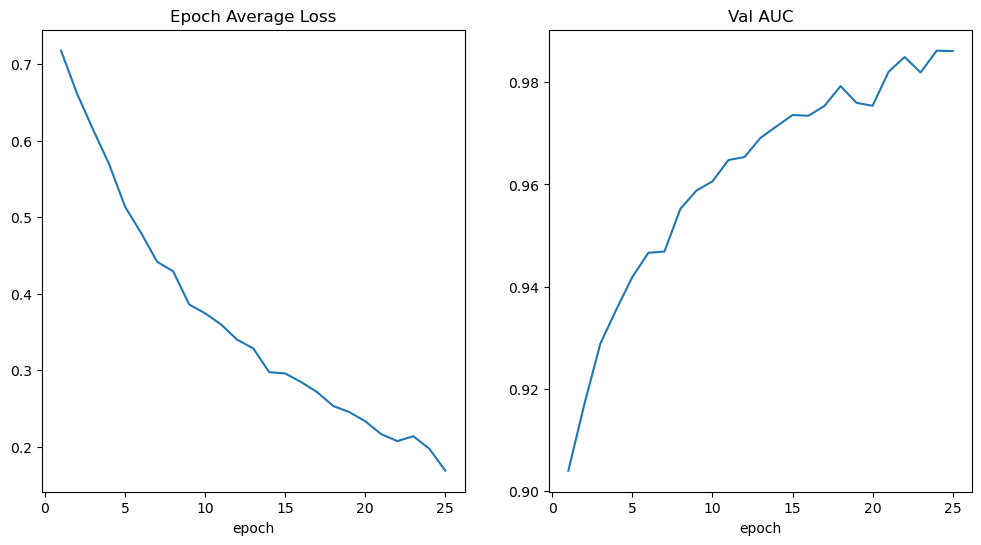

In [37]:
# Create a figure for the training plots with two subplots side by side

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1) # the first subplot for training loss
plt.title("Epoch Average Loss") # title of the first subplot
x = [i + 1 for i in range(len(epoch_loss_values))] # x-axis data points for training loss
y = epoch_loss_values # y-axis data points for training loss
plt.xlabel("epoch") # x-axis label for the first subplot
plt.plot(x, y) # plot the training loss curve in the first subplot

plt.subplot(1, 2, 2) # the second subplot for validation AUC
plt.title("Val AUC") # title of the second subplot
x = [val_interval * (i + 1) for i in range(len(metric_values))] # x-axis data points for validation AUC
y = metric_values # y-axis data points for validation AUC
plt.xlabel("epoch") # x-axis label for the second subplot
plt.plot(x, y) # plot the validation AUC curve in the second subplot

plt.show() # show the plot with both subplots

**Evaluate the model on test dataset**
<br>
Load the best model state dictionary, sets the model to evaluation mode, and makes predictions on the test data using the loaded model. The true labels and predicted labels are stored in separate lists.

In [38]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    # Loop over test data in batches
    for test_data in test_loader:
        # Get test images and labels, move them to GPU if available
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )

        # Get predicted labels for test images
        pred = model(test_images).argmax(dim=1)

        # Add true and predicted labels to the corresponding lists
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

**Print evaluation metrics**

In [39]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support



           2     0.9205    0.9488    0.9345       293

           3     0.9672    0.9725    0.9699       182

           1     0.8594    0.7971    0.8271       138



    accuracy                         0.9217       613

   macro avg     0.9157    0.9061    0.9105       613

weighted avg     0.9206    0.9217    0.9208       613




**References:**
<br>
Some parts of this code and applied methods are taken from our previous project work  at ENEL645.
<br>
Also, have taken some references from other Kaggle public notebooks.
<br>
**THANK YOU**